# Image automatic orientation detection
Task: 4 classes.

Classify if an image is correctly oriented (0°) or not
(affected by 90°, 180° or 270° orientation).


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Prepare data

In [ ]:
#@title Set paths
root_dir = '/content'

project_dir = '/drive/My Drive/AML project 2021-2-F1801Q151'
model_dir = root_dir + project_dir + '/models'
data_dir = root_dir + project_dir + '/datasets'

remote_indoor_dir = data_dir + '/indoor'
local_indoor_dir = root_dir + '/indoor'
indoor_train = '/RotatedImages.tar'
indoor_test = '/RotatedTestImages.tar'

remote_sun_dir = data_dir + '/sun/partition_01/224x224'
sun_train = '/RotatedImages_224.tar'
sun_test = '/RotatedTestImages_224.tar'
local_sun_dir = root_dir + '/sun'

#@markdown The subset of the Indoor dataset used contains originally _6661_ distinct images.

#@markdown The **first** of the ten official partitions of the SUN397 dataset contains originally _39700_ distinct images.

#@markdown Consequently, after generating a copy of each image in the four canonical orientations, _158800_ images corresponding to the **first** partition of SUN397 is obtained and _26644_ images corresponding to the Indoor dataset as well.

#@markdown As a result, the analysis includes **_185444_** images totally, which involves the **first** partition of the SUN397 dataset and the Indoor dataset.

In [ ]:
#@title Import modules
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import os
from shutil import copyfile
import tarfile
from time import time

print('TF version:', tf.__version__)
print('GPU: ', tf.config.list_physical_devices('GPU'))

TF version: 2.5.0
GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#@title Define helper functions

def createFolder(name) :
  if not os.path.exists(name):
    os.mkdir(name)

def transfer_ds(ds_name, remote_dir, local_dir):
  t0 = time()
  ds_source = remote_dir + ds_name
  ds_destination = local_dir + ds_name
  copyfile(ds_source, ds_destination)
  print('File transfer completed in %0.3f seconds' % (time() - t0))
  t1 = time()
  os.chdir(local_dir)
  tar = tarfile.open(ds_destination)
  tar.extractall()
  tar.close()
  os.chdir(root_dir)
  os.remove(ds_destination)
  print('File extraction completed in %0.3f seconds' % (time() - t1))

def confusion_matrix():
  y_pred = np.empty(shape=0, dtype=int)
  y_test = np.empty(shape=0, dtype=int)
  for images, labels in test_ds.take(100):
    probs = model.predict(images)
    preds = np.argmax(probs, axis=-1)
    y_pred = np.append(y_pred, preds)
    y_test = np.append(y_test, labels.numpy())
  cm = tf.math.confusion_matrix(labels=y_test,
                                predictions=y_pred,
                                num_classes=NUM_CLASSES)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]
  return cm

### Transfer datasets from Google Drive

#### Transfer indoorCVPR_09

In [ ]:
createFolder(local_indoor_dir)

In [ ]:
# Transfer indoor train dataset from GoogleDrive and extract it locally
transfer_ds(indoor_train, remote_indoor_dir, local_indoor_dir)

File transfer completed in 5.155 seconds
File extraction completed in 3.890 seconds


In [ ]:
# Transfer indoor test dataset from GoogleDrive and extract it locally
transfer_ds(indoor_test, remote_indoor_dir, local_indoor_dir)

File transfer completed in 1.653 seconds
File extraction completed in 0.963 seconds


#### Transfer SUN397

In [ ]:
createFolder(local_sun_dir)

In [ ]:
# Transfer sun train dataset from GoogleDrive and extract it locally
transfer_ds(sun_train, remote_sun_dir, local_sun_dir)

File transfer completed in 32.837 seconds
File extraction completed in 27.049 seconds


In [ ]:
# Transfer sun train dataset from GoogleDrive and extract it locally
transfer_ds(sun_test, remote_sun_dir, local_sun_dir)

File transfer completed in 49.371 seconds
File extraction completed in 30.558 seconds


### Load datasets

In [ ]:
# The following timer measures the duration of the entire analysis.
start_time = time()

In [ ]:
indoor_train_dir = local_indoor_dir + indoor_train.split('.')[0]
indoor_test_dir = local_indoor_dir + indoor_test.split('.')[0]

sun_train_dir = local_sun_dir + sun_train.split('.')[0]
sun_test_dir = local_sun_dir + sun_test.split('.')[0]

LABELS = 'inferred'
LABEL_MODE = 'int'
CLASS_NAMES = ['0', '180', '270', '90']
NUM_CLASSES = len(CLASS_NAMES)
COLOR_MODE = 'rgb'
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
SEED = 42
VALIDATION_SPLIT = 0.2
INTERPOLATION = 'bicubic'

#### Load indoorCVPR_09

In [ ]:
# Train
indoor_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    indoor_train_dir,
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    interpolation=INTERPOLATION,
    follow_links=False,
)

# Validation
indoor_validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    indoor_train_dir,
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    interpolation=INTERPOLATION,
    follow_links=False,
)

# Test
indoor_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    indoor_test_dir,
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=None,
    subset=None,
    interpolation=INTERPOLATION,
    follow_links=False,
)

Found 21292 files belonging to 4 classes.
Using 17034 files for training.
Found 21292 files belonging to 4 classes.
Using 4258 files for validation.
Found 5352 files belonging to 4 classes.


In [ ]:
assert isinstance(indoor_train_ds, tf.data.Dataset)
print('Number of train batches: %d' % tf.data.experimental.cardinality(indoor_train_ds))
assert isinstance(indoor_validation_ds, tf.data.Dataset)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(indoor_validation_ds))
assert isinstance(indoor_test_ds, tf.data.Dataset)
print('Number of test batches: %d' % tf.data.experimental.cardinality(indoor_test_ds))

Number of train batches: 267
Number of validation batches: 67
Number of test batches: 84


#### Load SUN397

In [ ]:
# Train
sun_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sun_train_dir,
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    interpolation=INTERPOLATION,
    follow_links=False,
)

# Validation
sun_validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sun_train_dir,
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    interpolation=INTERPOLATION,
    follow_links=False,
)

# Test
sun_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sun_test_dir,
    labels=LABELS,
    label_mode=LABEL_MODE,
    class_names=CLASS_NAMES,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=None,
    subset=None,
    interpolation=INTERPOLATION,
    follow_links=False,
)

Found 79400 files belonging to 4 classes.
Using 63520 files for training.
Found 79400 files belonging to 4 classes.
Using 15880 files for validation.
Found 79400 files belonging to 4 classes.


In [ ]:
assert isinstance(sun_train_ds, tf.data.Dataset)
print('Number of train batches: %d' % tf.data.experimental.cardinality(sun_train_ds))
assert isinstance(sun_validation_ds, tf.data.Dataset)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(sun_validation_ds))
assert isinstance(sun_test_ds, tf.data.Dataset)
print('Number of test batches: %d' % tf.data.experimental.cardinality(sun_test_ds))

Number of train batches: 993
Number of validation batches: 249
Number of test batches: 1241


### Merge datasets

In [ ]:
# Concatenate indoorCVPR09 and SUN397
train_ds = indoor_train_ds.concatenate(sun_train_ds)
validation_ds = indoor_validation_ds.concatenate(sun_validation_ds)
test_ds = indoor_test_ds.concatenate(sun_test_ds)

In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
assert isinstance(train_ds, tf.data.Dataset)
DATASET_NUM_TRAIN_BATCHES = tf.data.experimental.cardinality(train_ds).numpy()
print('Number of train batches: %d' % DATASET_NUM_TRAIN_BATCHES)

assert isinstance(validation_ds, tf.data.Dataset)
DATASET_NUM_VALIDATION_BATCHES = tf.data.experimental.cardinality(validation_ds).numpy()
print('Number of validation batches: %d' % DATASET_NUM_VALIDATION_BATCHES)

assert isinstance(test_ds, tf.data.Dataset)
DATASET_NUM_TEST_BATCHES = tf.data.experimental.cardinality(test_ds).numpy()
print('Number of test batches: %d' % DATASET_NUM_TEST_BATCHES)

Number of train batches: 1260
Number of validation batches: 316
Number of test batches: 1325


### Visualize

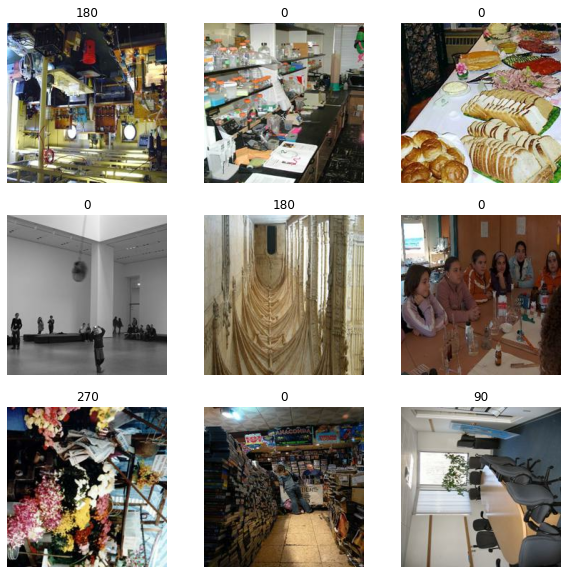

In [ ]:
# Show nine images and labels from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis('off')

## Transfer learning

### Build model

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
# Let's take a look at the base model architecture
vgg16.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# Build a feature extractor that converts each 224x224x3 image into a 4096 vector of features
# Apply a dense layer on top to convert these features into a single prediction per image
layers = [layer for layer in vgg16.layers]

inputs = tf.keras.Input(shape = IMAGE_SIZE + (3, ))
# preprocessing inside the model
x = tf.keras.applications.vgg16.preprocess_input(inputs)
# block_1
x = layers[1](inputs)
for i in range(2, 4):
  x = layers[i](x)
# block_2
for i in range(4, 7):
  x = layers[i](x)
# block_3
for i in range(7, 11):
  x = layers[i](x)
# block_4
for i in range(11, 15):
  x = layers[i](x)
x = tf.keras.layers.Dropout(0.15)(x)
# block_5 conv1
x = layers[15](x)
x = tf.keras.layers.BatchNormalization()(x)
# block_5 conv2
x = layers[16](x)
x = tf.keras.layers.BatchNormalization()(x)
# block_5 conv3
x = layers[17](x)
x = tf.keras.layers.BatchNormalization()(x)
# block_5 pool
x = layers[18](x)
x = tf.keras.layers.Dropout(0.15)(x)
# flatten
x = layers[19](x)
# fc1
x = layers[20](x)
# fc2
x = layers[21](x)
# head
x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES,
                                activation='softmax',
                                name= 'output')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Unfreeze all layers
model.trainable = True
# Freeze all layers before the head layer
head_index = 28
for layer in model.layers[:head_index]:
  layer.trainable = False
# Unfreeze BatchNormalization layers
model.layers[17].trainable = True
model.layers[19].trainable = True
model.layers[21].trainable = True

# Compile
lr = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')])
# Let's take a look at the new model architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train the head

In [ ]:
# Accuracy on the validation set, before training
val_loss, val_acc = model.evaluate(validation_ds)

316/316 [==============================] - 126s 272ms/step - loss: 2.7881 - acc: 0.2660


In [ ]:
# Train
initial_epochs = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    callbacks=[callback],
                    validation_data=validation_ds,
                    shuffle=True)

Epoch 1/10
1260/1260 [==============================] - 492s 389ms/step - loss: 0.9759 - acc: 0.5481 - val_loss: 0.7424 - val_acc: 0.6698
Epoch 2/10
1260/1260 [==============================] - 492s 390ms/step - loss: 0.7568 - acc: 0.6590 - val_loss: 0.6495 - val_acc: 0.7186
Epoch 3/10
1260/1260 [==============================] - 493s 391ms/step - loss: 0.6835 - acc: 0.7006 - val_loss: 0.5903 - val_acc: 0.7584
Epoch 4/10
1260/1260 [==============================] - 493s 391ms/step - loss: 0.6302 - acc: 0.7356 - val_loss: 0.5435 - val_acc: 0.7840
Epoch 5/10
1260/1260 [==============================] - 492s 390ms/step - loss: 0.5909 - acc: 0.7550 - val_loss: 0.5077 - val_acc: 0.8002
Epoch 6/10
1260/1260 [==============================] - 492s 390ms/step - loss: 0.5553 - acc: 0.7751 - val_loss: 0.4767 - val_acc: 0.8161
Epoch 7/10
1260/1260 [==============================] - 491s 389ms/step - loss: 0.5264 - acc: 0.7893 - val_loss: 0.4520 - val_acc: 0.8247
Epoch 8/10
1260/1260 [============

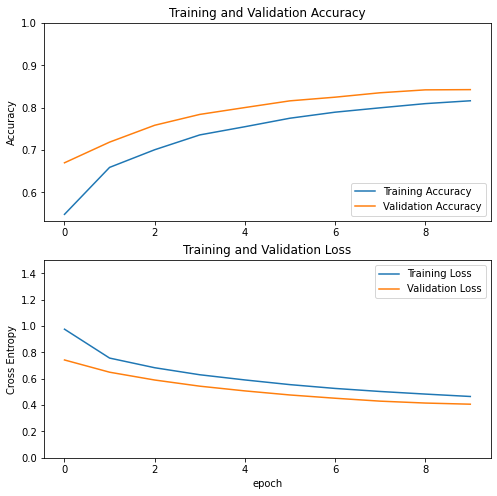

In [ ]:
#@title Learning curves using the base model as a fixed feature extractor
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
os.chdir(model_dir)
plt.savefig('vgg16_head.pdf')
os.chdir(root_dir)
plt.show()

#### Save model to Google Drive

In [ ]:
# Save model and architecture to Google Drive
os.chdir(model_dir)
model.save('vgg16_head.h5')
os.chdir(root_dir)

#### Load model from Google Drive

In [ ]:
# Load model and architecture from Google Drive
#os.chdir(model_dir)
#model = load_model('vgg16_head.h5')
#os.chdir(root_dir)

#### Test

In [ ]:
# Test the model
test_loss, test_accuracy = model.evaluate(test_ds, batch_size=BATCH_SIZE)

1325/1325 [==============================] - 387s 291ms/step - loss: 0.4004 - acc: 0.8445


Text(33.0, 0.5, 'True')

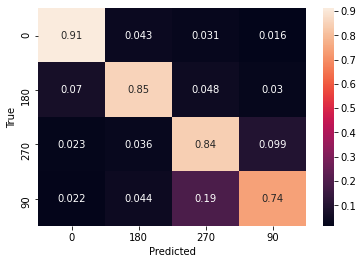

In [ ]:
# Plot confusion matrix
cm = confusion_matrix()
sns.heatmap(
    cm,
    annot=True,
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')

### Do a round of fine-tuning

In [ ]:
# Unfreeze
model.trainable = True
# Fine-tune from block5_conv1 layer onwards
fine_tune_at = 16
# Freeze all the layers before the 'fine_tune_at' layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# Compile
lr = 1e-6  # previously was lr=1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),  
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')])
# Let's take a look at the new model architecture
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Re-training the model end-to-end with a very low learning rate to avoid overfit!
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         callbacks=[callback],
                         validation_data=validation_ds,
                         initial_epoch=history.epoch[-1],
                         shuffle=True)

Epoch 10/13
1260/1260 [==============================] - 554s 439ms/step - loss: 0.3511 - acc: 0.8663 - val_loss: 0.2544 - val_acc: 0.9073
Epoch 11/13
1260/1260 [==============================] - 552s 438ms/step - loss: 0.2461 - acc: 0.9082 - val_loss: 0.2158 - val_acc: 0.9207
Epoch 12/13
1260/1260 [==============================] - 552s 438ms/step - loss: 0.1948 - acc: 0.9285 - val_loss: 0.1959 - val_acc: 0.9280
Epoch 13/13
1260/1260 [==============================] - 553s 438ms/step - loss: 0.1589 - acc: 0.9418 - val_loss: 0.1826 - val_acc: 0.9342


#### Save model to Google Drive

In [ ]:
# Save model and architecture to Google Drive
os.chdir(model_dir)
model.save('vgg16_block5_conv1.h5')
os.chdir(root_dir)

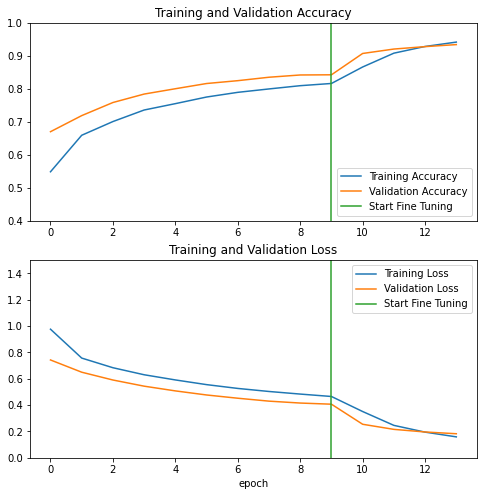

In [ ]:
#@title Learning curves training from 'block5_conv1' layer
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
os.chdir(model_dir)
plt.savefig('vgg16_block5_conv1.pdf')
os.chdir(root_dir)
plt.show()

#### Load model from Google Drive

In [ ]:
# Load model and architecture from Google Drive
#os.chdir(model_dir)
#model = load_model('vgg16_head.h5')
#os.chdir(root_dir)

#### Test

In [ ]:
# Evaluation and prediction
final_loss, final_accuracy = model.evaluate(test_ds)

1325/1325 [==============================] - 380s 286ms/step - loss: 0.1272 - acc: 0.9577


Text(33.0, 0.5, 'True')

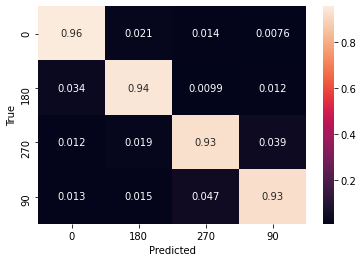

In [ ]:
# Plot confusion matrix
cm = confusion_matrix()
sns.heatmap(
    cm,
    annot=True,
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES)
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
print('Analysis completed in %0.3f seconds' % (time() - start_time))

Analysis completed in 8283.512 seconds


## Optional: Deployment to TensorFlow Lite

In [ ]:
# Load model and architecture from Google Drive
os.chdir(model_dir)
model = load_model('vgg16_block5_conv1.h5')
os.chdir(root_dir)

In [ ]:
import itertools
#@title Optimization settings
optimize_lite_model = True  #@param {type:"boolean"}
integer_only = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 400  #@param {type:"slider", min:0, max:640, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in validation_ds.take(10) for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
    if integer_only:
      # Ensure that if any ops can't be quantized, the converter throws an error
      converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
      # Set the input and output tensors to uint8 (APIs added in r2.3)
      converter.inference_input_type = tf.uint8  # or tf.int8
      converter.inference_output_type = tf.uint8  # or tf.int8

lite_model_content = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpb06jtsrn/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  # Check if the input type is quantized, then rescale input data to uint8
  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details['quantization']
    images = images / input_scale + input_zero_point
    images = images.numpy().astype(input_details['dtype'])
  interpreter.set_tensor(input_details['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(output_details['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 5  #@param {type:"slider", min:0, max:640}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in test_ds.take(10)
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = label
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 5 of 5 examples (100%).
TF Lite model is accurate on 5 of 5 examples (100%).


In [ ]:
# Save converted model
os.chdir(model_dir)
model_name = 'vgg16_block5_conv1'
with open(f'{model_name}%s.tflite' %
          ('_optimized' if optimize_lite_model else ''), 'wb') as f:
  f.write(lite_model_content)
print('Wrote %sTFLite model of %d bytes.' %
      ('optimized ' if optimize_lite_model else '',
       len(lite_model_content)))
os.chdir(root_dir)

Wrote optimized TFLite model of 134433016 bytes.
